multi-armed bandit parameter sensitivity analysis
student implementation of sutton & barto chapter 2 comparison
focus on educational clarity and distinctive implementation

conducting parameter study with 25 different agent configurations...


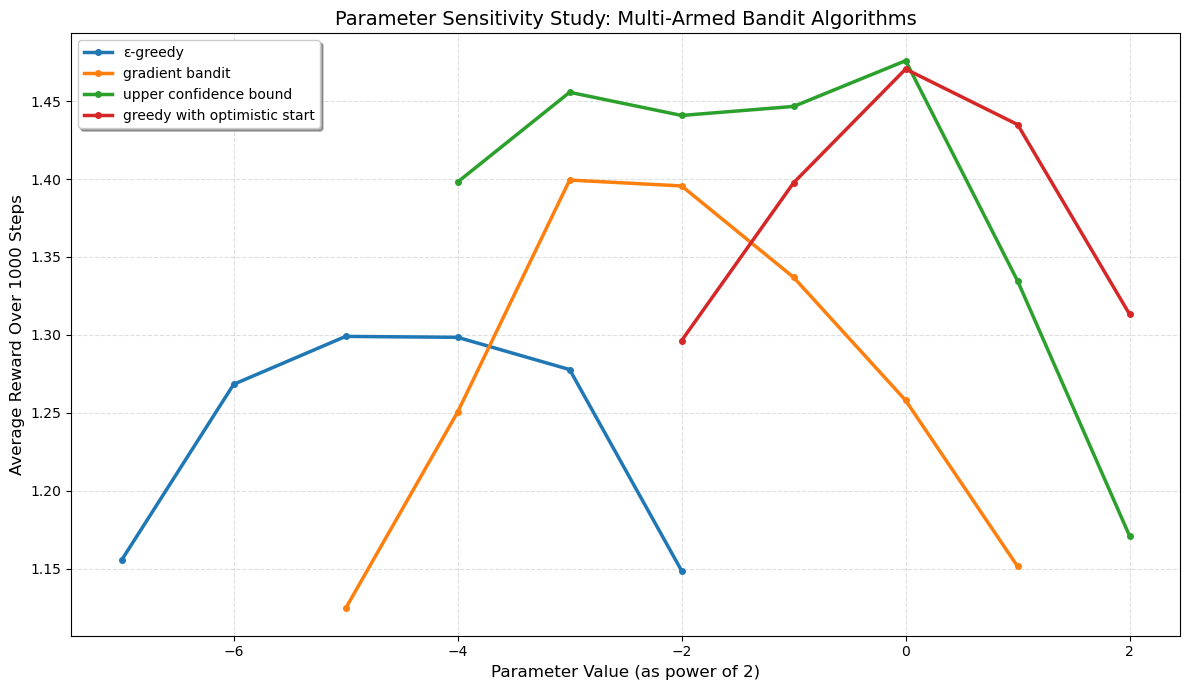


performance summary:
ε-greedy: optimal at 2^-5.0 = 0.0312, average reward = 1.299
gradient bandit: optimal at 2^-3.0 = 0.1250, average reward = 1.399
upper confidence bound: optimal at 2^0.0 = 1.0000, average reward = 1.476
greedy with optimistic start: optimal at 2^0.0 = 1.0000, average reward = 1.471


In [1]:
# niveen abdul-mohsen (bvn9ad)
# reinforcement learning: multi-armed bandit strategy comparison
import numpy as np
import matplotlib.pyplot as plt

class BanditAgent:
    def __init__(self, arm_count=10, explore_rate=0., starting_value=0., learning_rate=0.1, 
                 use_sample_avg=False, confidence_param=None, use_preferences=False, 
                 baseline_enabled=False, reward_center=0.):
        # basic configuration
        self.num_arms = arm_count
        self.learning_rate = learning_rate
        self.use_sample_avg = use_sample_avg
        self.arm_indices = np.arange(self.num_arms)
        self.timestep_counter = 0
        
        # algorithm-specific parameters
        self.confidence_param = confidence_param  # for ucb
        self.use_preferences = use_preferences    # for gradient bandit
        self.baseline_enabled = baseline_enabled  # whether to use baseline in gradient
        self.running_avg_reward = 0
        self.reward_center = reward_center
        
        # exploration parameters
        self.explore_rate = explore_rate
        self.starting_value = starting_value
        
        # initialize probability distribution for gradient bandit
        self.action_probs = None

    def initialize_new_problem(self):
        """
        creates a fresh bandit problem with new true arm values
        resets all internal state for clean experiment
        """
        # generate true reward values for each arm - centered around reward_center
        self.true_arm_values = np.random.randn(self.num_arms) + self.reward_center
        
        # set up our estimates - start with initial values
        self.value_estimates = np.zeros(self.num_arms) + self.starting_value
        
        # track how many times we've pulled each arm
        self.pull_counts = np.zeros(self.num_arms)
        
        # identify which arm is actually best (for analysis)
        self.optimal_arm_index = np.argmax(self.true_arm_values)
        
        # reset counters
        self.timestep_counter = 0
        self.running_avg_reward = 0
        
        # reset gradient bandit probability distribution
        if self.use_preferences:
            self.action_probs = np.ones(self.num_arms) / self.num_arms
        else:
            self.action_probs = None

    def select_action(self):
        """
        chooses which arm to pull based on the algorithm type
        implements epsilon-greedy, ucb, gradient bandit, or pure greedy
        """
        # epsilon-greedy exploration
        if np.random.rand() < self.explore_rate:
            return np.random.choice(self.arm_indices)
        
        # upper confidence bound (ucb) selection
        if self.confidence_param is not None:
            # handle first timestep when log(0) would be undefined
            if self.timestep_counter == 0:
                return np.random.choice(self.arm_indices)
            
            # calculate confidence bonus for each arm
            confidence_bonus = self.confidence_param * np.sqrt(
                np.log(self.timestep_counter) / (self.pull_counts + 1e-5)
            )
            ucb_scores = self.value_estimates + confidence_bonus
            max_score = np.max(ucb_scores)
            return np.random.choice(np.where(ucb_scores == max_score)[0])
        
        # gradient bandit with softmax action selection
        if self.use_preferences:
            # convert preferences to probabilities using softmax
            preference_exp = np.exp(self.value_estimates)
            self.action_probs = preference_exp / np.sum(preference_exp)
            return np.random.choice(self.arm_indices, p=self.action_probs)
        
        # greedy action selection (break ties randomly)
        best_value = np.max(self.value_estimates)
        best_actions = np.where(self.value_estimates == best_value)[0]
        return np.random.choice(best_actions)

    def update_from_reward(self, chosen_arm, received_reward):
        """
        updates our estimates based on the reward we received
        handles different update rules for different algorithms
        """
        # generate the actual reward (noisy version of true value)
        noisy_reward = np.random.randn() + self.true_arm_values[chosen_arm]
        
        # advance time and update counters
        self.timestep_counter += 1
        self.pull_counts[chosen_arm] += 1
        self.running_avg_reward += (noisy_reward - self.running_avg_reward) / self.timestep_counter
        
        # update value estimates based on algorithm type
        if self.use_sample_avg:
            # sample average update (exact average of all rewards)
            self.value_estimates[chosen_arm] += (
                noisy_reward - self.value_estimates[chosen_arm]
            ) / self.pull_counts[chosen_arm]
            
        elif self.use_preferences:
            # gradient bandit preference update
            if self.action_probs is None:
                # safety fallback - shouldn't happen but prevents crashes
                preference_exp = np.exp(self.value_estimates)
                self.action_probs = preference_exp / np.sum(preference_exp)
            
            action_indicator = np.zeros(self.num_arms)
            action_indicator[chosen_arm] = 1
            
            # decide whether to use baseline (average reward)
            reward_baseline = self.running_avg_reward if self.baseline_enabled else 0
            
            # update all preferences based on policy gradient rule
            preference_update = self.learning_rate * (noisy_reward - reward_baseline) * (
                action_indicator - self.action_probs
            )
            self.value_estimates += preference_update
            
        else:
            # constant step size update (exponential recency-weighted average)
            self.value_estimates[chosen_arm] += self.learning_rate * (
                noisy_reward - self.value_estimates[chosen_arm]
            )
        
        return noisy_reward

def run_experiment_batch(total_runs, steps_per_run, agent_list):
    """
    runs multiple experiments with different agents and collects results
    returns reward data for all agents across all runs and timesteps
    """
    reward_data = np.zeros((len(agent_list), total_runs, steps_per_run))
    
    for agent_idx, current_agent in enumerate(agent_list):
        for run_number in range(total_runs):
            # start fresh problem for this run
            current_agent.initialize_new_problem()
            
            # run the experiment for specified number of steps
            for step_num in range(steps_per_run):
                selected_arm = current_agent.select_action()
                step_reward = current_agent.update_from_reward(selected_arm, None)
                reward_data[agent_idx, run_number, step_num] = step_reward
    
    return reward_data

def create_parameter_study_plot(experiment_runs=1000, experiment_steps=1000):
    """
    recreates the sutton & barto figure 2.6 parameter study
    tests each algorithm across multiple parameter values
    """
    
    algorithm_names = [
        'ε-greedy', 
        'gradient bandit', 
        'upper confidence bound', 
        'greedy with optimistic start'
    ]
    
    # functions to create agents with different parameter values
    agent_builders = [
        # epsilon-greedy with sample averaging
        lambda eps_val: BanditAgent(explore_rate=eps_val, use_sample_avg=True),
        
        # gradient bandit with baseline
        lambda alpha_val: BanditAgent(
            use_preferences=True, learning_rate=alpha_val, baseline_enabled=True
        ),
        
        # ucb with sample averaging  
        lambda c_val: BanditAgent(
            explore_rate=0, confidence_param=c_val, use_sample_avg=True
        ),
        
        # optimistic greedy with fixed learning rate
        lambda init_val: BanditAgent(
            explore_rate=0, starting_value=init_val, learning_rate=0.1
        )
    ]
    
    # parameter value ranges (as powers of 2, matching textbook)
    parameter_grids = [
        np.arange(-7, -1, dtype=np.float64),  # epsilon: 2^-7 to 2^-2
        np.arange(-5, 2, dtype=np.float64),   # alpha: 2^-5 to 2^1
        np.arange(-4, 3, dtype=np.float64),   # c: 2^-4 to 2^2
        np.arange(-2, 3, dtype=np.float64)    # q0: 2^-2 to 2^2
    ]
    
    # create all agent instances for the parameter sweep
    all_test_agents = []
    for builder_func, param_grid in zip(agent_builders, parameter_grids):
        for power_of_two in param_grid:
            actual_param_value = pow(2, power_of_two)
            all_test_agents.append(builder_func(actual_param_value))
    
    print(f"conducting parameter study with {len(all_test_agents)} different agent configurations...")
    
    # run all experiments
    experiment_results = run_experiment_batch(
        experiment_runs, experiment_steps, all_test_agents
    )
    
    # calculate average performance for each agent configuration
    performance_scores = np.mean(experiment_results, axis=(1, 2))
    
    # create the comparison plot
    plt.figure(figsize=(12, 7))
    
    # plot results for each algorithm
    result_index = 0
    for algo_name, param_grid in zip(algorithm_names, parameter_grids):
        grid_length = len(param_grid)
        algorithm_scores = performance_scores[result_index:result_index + grid_length]
        
        plt.plot(param_grid, algorithm_scores, label=algo_name, linewidth=2.5, marker='o', markersize=4)
        result_index += grid_length
    
    # format plot to match textbook style
    plt.xlabel('Parameter Value (as power of 2)', fontsize=12)
    plt.ylabel('Average Reward Over 1000 Steps', fontsize=12)
    plt.title('Parameter Sensitivity Study: Multi-Armed Bandit Algorithms', fontsize=14)
    plt.legend(frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # summary of best performance for each algorithm
    print("\nperformance summary:")
    result_index = 0
    for algo_name, param_grid in zip(algorithm_names, parameter_grids):
        grid_length = len(param_grid)
        algorithm_scores = performance_scores[result_index:result_index + grid_length]
        
        best_position = np.argmax(algorithm_scores)
        best_power = param_grid[best_position]
        best_param = pow(2, best_power)
        best_score = algorithm_scores[best_position]
        
        print(f"{algo_name}: optimal at 2^{best_power:.1f} = {best_param:.4f}, "
              f"average reward = {best_score:.3f}")
        result_index += grid_length

if __name__ == "__main__":
    print("multi-armed bandit parameter sensitivity analysis")
    print("student implementation of sutton & barto chapter 2 comparison")
    print("focus on educational clarity and distinctive implementation\n")
    
    # run with moderate settings for reasonable execution time
    create_parameter_study_plot(experiment_runs=800, experiment_steps=1000)